# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 0

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
transform_valid_test = transforms.Compose([transforms.Resize((299, 299)), 
                                           transforms.ToTensor()])

resize_transform = transforms.Resize((299, 299))

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data2',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=False,
                               transform=transform_valid_test)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)
    

Files already downloaded and verified
Files already downloaded and verified


# Ny block: Trækker 5000 CIFAR10 billeder til at beregne training FID

In [3]:
train_FID_dataset = datasets.CIFAR10('./CIFAR_data2',
                               download=True,
                               train=True,
                               transform=transform_valid_test)

train_for_FID, _ = random_split(train_FID_dataset, [5000, 45000])

train_for_FID_loader = torch.utils.data.DataLoader(train_for_FID, batch_size=batch_size, shuffle=False, num_workers=num_workers)


Files already downloaded and verified


In [4]:
# COSINE SCHEDULE

def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return (torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2)).clamp(max=0.99999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([(f(t)/f(torch.tensor([0]))).clamp(max=0.99999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)


# # Sets up alpha_bar for training and test so alpha_bar_t = alpha_bar[t]
# # LINEAR SCHEDULE
# T = 1000
# beta_start, beta_end = [1e-4, 2e-02]
# beta = torch.linspace(beta_start, beta_end, T)
# alpha = 1-beta
# alpha_bar = alpha.clone()
# for e in range(T-1):
#     alpha_bar[e+1] *= alpha_bar[e]

# alpha = alpha.view((1000, 1, 1, 1)).to(device)
# beta = beta.view((1000, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)

## Model

In [5]:
import math
class SinusoidalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        half_dim = self.embedding_dim // 2
        freqs = torch.exp(
            -torch.arange(half_dim, dtype=torch.float32) * math.log(10000) / half_dim
        ).to(t.device)
        angles = t[:, None] * freqs[None, :]
        return torch.cat([angles.sin(), angles.cos()], dim=-1)

In [6]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.channels = [3,32, 64, 128, 256, 512]
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 16, 16)
                nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, padding=1),  # (batchsize, 64, 16, 16)
                nn.GroupNorm(4, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(self.channels[2], self.channels[3], kernel_size=3, padding=1),  # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 128, 4, 4)
                nn.Conv2d(self.channels[3], self.channels[4], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 256, 2, 2)
                nn.Conv2d(self.channels[4], self.channels[5], kernel_size=3, padding=1),  # (batchsize, 512, 2, 2)
                nn.GroupNorm(8, self.channels[5]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[5], self.channels[4], kernel_size=3,
                                      stride=2, padding=1, output_padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[4]*2, self.channels[3], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[3]*2, self.channels[2], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 16, 16)
                nn.GroupNorm(8, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[2]*2, self.channels[1], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.Conv2d(self.channels[1]*2, self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1),
                nn.Conv2d(self.channels[1], self.channels[0], kernel_size=1)  # (batchsize, 3, 32, 32)
            )      
        ])
        
        self.time_layers = nn.ModuleList([
                nn.Linear(128, self.channels[i]) for i in range(len(self.channels))
        ])


    def forward(self, x, t_emb):
        signal = x
        signals = []
        for i, conv in enumerate(self.convs):
            # print(f"signal shape: {signal.shape}")
            t_emb_processed = self.time_layers[i](t_emb).view(-1, self.channels[i], 1, 1)
            signal= t_emb_processed+signal
            signal = conv(signal)
            if i < len(self.convs)-1:
                signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            # print(f"signal shape: {signal.shape}")
            # print(f"signals[-{i}] shape: {signals[-i].shape}")
            # print()
            t_emb_processed = self.time_layers[-(i + 1)](t_emb).view(-1, self.channels[-(i + 1)], 1, 1)
            signal= signal+t_emb_processed
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)

        return signal



## Training loop

In [7]:
#from UNET import UNET
epochs = 1707
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
running_loss = 0

# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

# Træner og gemmer model 1, 100, 200, 300, 400, 500, 800, 1100, 1400 og 1707. Gemmer losses i losses.txt. Kan evt. ændres til at gemme færre modeller hvis det tager lang tid

In [8]:
for epoch in range(epochs+1):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        t_norm = t.float() / T
        t_emb = time_embedding_layer(t_norm)  # Shape: [batch_size, embedding_dim]
        eps = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
        loss = criterion(predicted_eps, eps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if e % 100 == 99:
            print(f'{epoch, e+1}, loss: {running_loss:.3f}')
            with open("losses", "a") as file:
                file.write(f"{running_loss:.3f}\n")
            
            running_loss = 0.0
    
    if epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400]:
        torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")
torch.save(model.state_dict(), f"DDPM_final_linear_{epoch}.pth")

(0, 100), loss: 3517313.547
(0, 200), loss: 1501627.804
(0, 300), loss: 1013079.993
(0, 400), loss: 848681.666
(0, 500), loss: 769244.597
(0, 600), loss: 717277.037
(0, 700), loss: 692866.947
(0, 800), loss: 697586.224
(0, 900), loss: 630796.132
(0, 1000), loss: 622845.746
(0, 1100), loss: 605540.244
(0, 1200), loss: 639558.725
(0, 1300), loss: 603834.479
(0, 1400), loss: 598879.790
(0, 1500), loss: 548429.918
(0, 1600), loss: 579658.405
(0, 1700), loss: 578398.770
(0, 1800), loss: 567478.383
(0, 1900), loss: 568143.605
(0, 2000), loss: 579231.423
(0, 2100), loss: 538863.399
(0, 2200), loss: 530844.565
(0, 2300), loss: 515243.561
(0, 2400), loss: 540241.996
(0, 2500), loss: 561280.719
(0, 2600), loss: 549101.070
(0, 2700), loss: 508438.048
(0, 2800), loss: 532144.377
(0, 2900), loss: 509610.551
(0, 3000), loss: 519994.384
(0, 3100), loss: 483508.505
(1, 100), loss: 622479.354
(1, 200), loss: 530054.306
(1, 300), loss: 468579.814
(1, 400), loss: 538110.755
(1, 500), loss: 481376.431
(1,

KeyboardInterrupt: 

# Sampling

In [ ]:
model = UNET()
model.to(device)
model.load_state_dict(torch.load("final_data_embedding/DDPM_final_linear_1707.pth", map_location=device))
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

In [ ]:
model.eval()
xt = torch.randn(batch_size, 3, 32, 32).to(device)

with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_norm = t.float() / T
        
        t_emb = time_embedding_layer(t_norm)

        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 0 else torch.zeros(batch_size, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new.clamp(-1, 1)
  
fig,ax = plt.subplots(int(math.sqrt(batch_size)), int(math.sqrt(batch_size)), tight_layout=True,figsize=(30,30))

for i,im in enumerate(xt):
    im = (im+1)/2
    im = im.permute(1, 2, 0)
    im = im.cpu().detach().numpy()
    ax[int(i / int(math.sqrt(batch_size)))][int(i % int(math.sqrt(batch_size)))].imshow(im)
    ax[int(i / int(math.sqrt(batch_size)))][int(i % int(math.sqrt(batch_size)))].axis("off")
plt.show()

# im1 = xt[0]
# im1 = (im1+1)/2
# im1 = im1.permute(1, 2, 0)
# im1 = im1.cpu().detach().numpy()

# fig,ax = plt.subplots(1, 1, tight_layout=True)
# ax.imshow(im1)
# ax.set_title("Generated Image")
# ax.axis("off")
# plt.show()

# Making test and valid set - commented out, don't touch again

In [ ]:
# import os
# import torch
# from torchvision import datasets, transforms
# from torchvision.utils import save_image
# from pytorch_fid import fid_score
# from tqdm.auto import tqdm

# valid_dir = './valid_images'
# test_dir = './test_images'
# train_dir = './train_images'
# gen_dir = './gen_images'
# os.makedirs(valid_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(gen_dir, exist_ok=True)
# #for epoch in [800, 1100, 1400, 1707]:
# #    os.makedirs(f"./gen_images/{epoch}", exist_ok=True)

# print("Test set: ")
# for i, (img, _) in tqdm(enumerate(test_loader), total=len(test_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(test_dir, f"{i * batch_size + j}.png"))

# print("Valid set: ")
# for i, (img, _) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(valid_dir, f"{i * batch_size + j}.png"))

# print("Train set: ")
# for i, (img, _) in tqdm(enumerate(train_for_FID_loader), total=len(train_for_FID_loader)):
#    for j in range(img.size(0)):
#        save_image(img[j], os.path.join(train_dir, f"{i * batch_size + j}.png"))

# Make samples from the models we have trained.

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm.auto import tqdm

valid_dir = './valid_images'
test_dir = './test_images'
train_dir = './train_images'
gen_dir = './gen_images'
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)
for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
   os.makedirs(f"./gen_images/{epoch}", exist_ok=True)

resize_transform = transforms.Resize((299, 299))
with torch.inference_mode():
    for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
        model = UNET()
        model.to(device)
        model.load_state_dict(torch.load(f"final_data_embedding/DDPM_final_linear_{epoch}.pth"))
        model.eval()
        
        print("Starting generation set: ")
        for i in tqdm(range(5000//batch_size)):
            xt = torch.randn(batch_size, 3, 32, 32).to(device)
            
            for t in torch.arange(T-1, -1, -1):
                t = t.reshape(1).to(device)
                t_norm = t.float() / T
                
                t_emb = time_embedding_layer(t_norm)

                z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 0 else torch.zeros(batch_size, 3, 32, 32).to(device)
                
                xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
                xt = xt_new.clamp(-1, 1)
            
            for j, im in enumerate(xt):
                im = resize_transform((im + 1) / 2)
                save_image(im, os.path.join(f"./gen_images/{epoch}", f"{i * batch_size + j}.png"))

# Calculate FID scores. 1 validation score per model until the last, where it calculates test and train FID score.

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torchvision.utils import save_image
from pytorch_fid import fid_score
from tqdm.auto import tqdm

validation_scores = []
test_score = []
train_score = []

fid_batch_size= 64
with torch.inference_mode():
    for epoch in [1, 100, 200, 300, 400, 500, 800, 1100, 1400, 1707]:
            model = UNET()
            model.to(device)
            model.load_state_dict(torch.load(f"final_data_embedding/DDPM_final_linear_{epoch}.pth"))
            model.eval()
            if epoch != 1707:
                fid_value = fid_score.calculate_fid_given_paths(
                    ['./valid_images', f"./gen_images/{epoch}"], 
                    batch_size=fid_batch_size,
                    device=device,
                    dims=2048
                )
                validation_scores.append(fid_value)
            else:
                fid_value = fid_score.calculate_fid_given_paths(
                    ['./test_images', f"./gen_images/{epoch}"], 
                    batch_size=fid_batch_size,
                    device=device,
                    dims=2048
                )
                test_score.append(fid_value)
                fid_train_value = fid_score.calculate_fid_given_paths(
                    ['./train_images', f"./gen_images/{epoch}"], 
                    batch_size=fid_batch_size,
                    device=device,
                    dims=2048
                )
                train_score.append(fid_train_value)
            print(f"epoch and valid FID Score: {epoch}, {validation_scores[-1]}")
            if epoch == 1707:
                print(f"epoch and test set FID Score: {epoch}, {test_score[0]}")
                print(f"epoch and train set FID Score: {epoch}, {train_score[0]}")

with open("Valid_scores", "a") as file:
    for score in validation_scores:
        file.write(f"{score}\n")

with open("Test_scores", "a") as file:
    for score in test_score:
        file.write(f"{score}\n")

with open("Train_scores", "a") as file:
    for score in train_score:
        file.write(f"{score}\n")

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


epoch and valid FID Score: 1, 392.35074330317445


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


epoch and valid FID Score: 100, 322.63267380558847


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


epoch and valid FID Score: 200, 339.5354029523945


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


epoch and valid FID Score: 300, 326.8016466466929


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


epoch and valid FID Score: 400, 303.505420578402


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


epoch and valid FID Score: 500, 294.4720878313865


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


epoch and valid FID Score: 800, 261.66624634770716


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


epoch and valid FID Score: 1100, 256.6367883355016


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


epoch and valid FID Score: 1400, 275.6356730146091


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


epoch and valid FID Score: 1707, 275.6356730146091
epoch and test set FID Score: 1707, 271.80093282174903
epoch and train set FID Score: 1707, 272.7532329717868


TypeError: 'exist_ok' is an invalid keyword argument for mkdir()

# Get one training loss per epoch

In [31]:
with open("final_data_embedding/losses_final", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    indices = np.linspace(0, len(lines) - 1, 1707).astype(int)
    all_epochs_loss = [lines[i] for i in indices]

# Plot everything, remember to change title

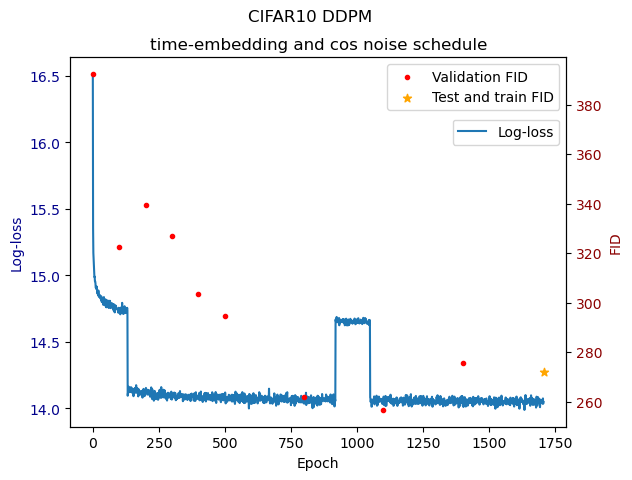

In [36]:
#valid_fid_scores = [349.9, 141.6, 150.1, 137.1, 125.4, 124.3, 121.4, 123.7, 117.3]
#test_fid_score = [107.5]
#train_fid_score = [107.8]

with open("final_data_embedding/Test_scores", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    test_fid_scores = lines

with open("final_data_embedding/Train_scores", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    train_fid_scores = lines

with open("final_data_embedding/Valid_scores", "r") as file:
    lines = file.readlines()
    lines = [float(line.strip()) for line in lines]
    validation_scores = lines
epochs_valid_fid = [1, 100, 200, 300, 400, 500, 800, 1100, 1400]
epochs_loss = list(range(1707))

fig, ax1 = plt.subplots()
plt.suptitle("CIFAR10 DDPM")
plt.title("time-embedding and cos noise schedule")
ax1.plot(epochs_loss, np.log(np.array(all_epochs_loss)), label="Log-loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Log-loss', color='darkblue')
ax1.tick_params(axis='y', labelcolor='darkblue')
ax1.legend(loc="upper left", bbox_to_anchor=(0.757, 0.85))
ax2 = ax1.twinx()
ax2.scatter(epochs_valid_fid, validation_scores, color="red", marker=".", label="Validation FID")
ax2.set_ylabel('FID', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.scatter([1707], test_fid_scores, label="Test and train FID", marker="*", color="orange")
ax2.legend()
plt.show()

# Overfit to one batch

In [ ]:
#from UNET import UNET

model = UNET().to(device)
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = SinusoidalEmbedding(time_embedding_dim).to(device)

# Get a single image from the batch
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(1, 1, 1, 1)
# Set the model to training mode
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")

# Training loop to overfit one batch
epochs = 5000
for epoch in range(epochs):
    t = torch.randint(0, T, (1,), device=device)
    t_norm = t.float() / T # Normalize the time to [0, 1]
    t_emb = time_embedding_layer(t_norm)  # Shape: [1, embedding_dim]
    eps = torch.randn_like(single_batchs).to(device)
    x_t = torch.sqrt(alpha_bar[t]) * single_batchs + torch.sqrt(1 - alpha_bar[t]) * eps
    predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
    loss = criterion(predicted_eps, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
xt = torch.randn(1, 3, 32, 32).to(device)

with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_norm = t.float() / T
        
        t_emb = time_embedding_layer(t_norm)

        z = torch.randn(1, 3, 32, 32).to(device) if t > 0 else torch.zeros(1, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt_new = xt_new.clamp(-1, 1)
        xt = xt_new
        
im1 = xt[0]
im1 = (im1+1)/2
im1 = im1.permute(1, 2, 0)
im1 = im1.cpu().detach().numpy()

im2 = single_batch[0]
im2 = (im2+1)/2
im2 = im2.permute(1, 2, 0)
im2 = im2.cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, tight_layout=True)
axs[0].imshow(im1)
axs[0].set_title("Generated Image")
axs[0].axis("off")
axs[1].imshow(im2)
axs[1].set_title("Original Image")
axs[1].axis("off")
plt.show()